In [53]:
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
import imghdr
from matplotlib import pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger

In [4]:
if tf.test.is_gpu_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is not available.


In [5]:
data_dir = 'C:/Projects/Malaria Cell Prediction using CNN/Dataset/cell_images/cell_images' 

In [6]:
image_exts = ['png']

In [7]:
img = cv2.imread(os.path.join(data_dir,"Parasitized","C33P1thinF_IMG_20150619_114756a_cell_179.png"))
img.shape

(163, 142, 3)

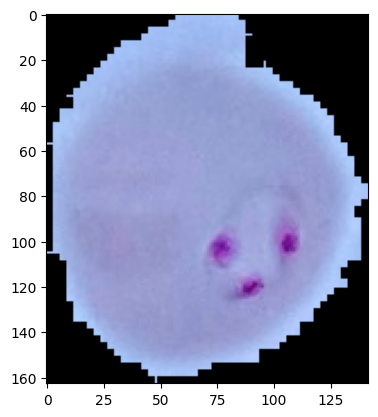

In [8]:
plt.imshow(img)

In [9]:
for image_class in tqdm(os.listdir(data_dir)): 
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

100%|██████████| 2/2 [04:51<00:00, 145.99s/it]


In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 27558 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
data_iterator

In [15]:
batch = data_iterator.next()

In [16]:
batch[0].shape

(32, 256, 256, 3)

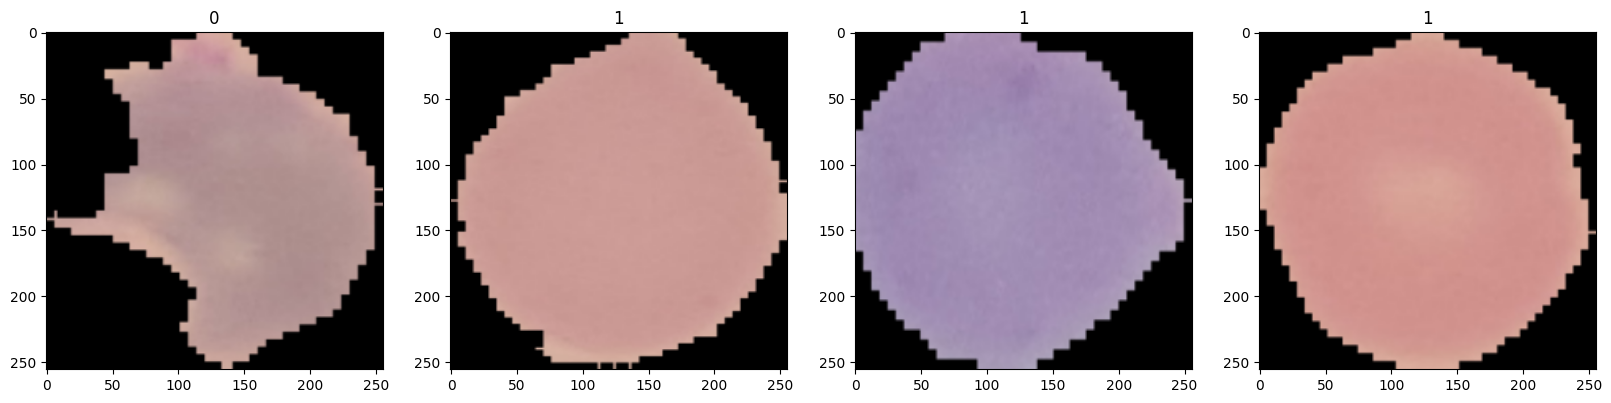

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [18]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [19]:
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next()[0].max()

0.949831

In [21]:
data.as_numpy_iterator().next()[0].min()

0.0

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [23]:
train_size

603

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [25]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
test

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
val

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file='Model_Architecture/model.png',   
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [44]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,           
    restore_best_weights=True  
)

In [46]:
model_checkpoint = ModelCheckpoint(
    'Model/best_model.h5',       
    monitor='val_loss',
    save_best_only=True,    
    mode='min'             
)

In [47]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [48]:
logdir='logs'

In [49]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [54]:
csv_logger = CSVLogger('training_log.csv', append=True)

In [55]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback,early_stopping,model_checkpoint,csv_logger])

Epoch 1/20


603/603 [==============================] - 214s 355ms/step - loss: 0.2349 - accuracy: 0.9224 - val_loss: 0.1823 - val_accuracy: 0.9417
Epoch 2/20


c:\Users\koush\anaconda3\envs\main\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


603/603 [==============================] - 159s 263ms/step - loss: 0.1866 - accuracy: 0.9379 - val_loss: 0.1685 - val_accuracy: 0.9448
Epoch 3/20
603/603 [==============================] - 160s 265ms/step - loss: 0.1534 - accuracy: 0.9509 - val_loss: 0.1685 - val_accuracy: 0.9497
Epoch 4/20
603/603 [==============================] - 182s 302ms/step - loss: 0.1323 - accuracy: 0.9568 - val_loss: 0.1605 - val_accuracy: 0.9482
Epoch 5/20
603/603 [==============================] - 173s 286ms/step - loss: 0.0992 - accuracy: 0.9654 - val_loss: 0.1965 - val_accuracy: 0.9473
Epoch 6/20
603/603 [==============================] - 172s 285ms/step - loss: 0.0789 - accuracy: 0.9719 - val_loss: 0.1800 - val_accuracy: 0.9506
Epoch 7/20
603/603 [==============================] - 169s 280ms/step - loss: 0.0584 - accuracy: 0.9805 - val_loss: 0.2156 - val_accuracy: 0.9473


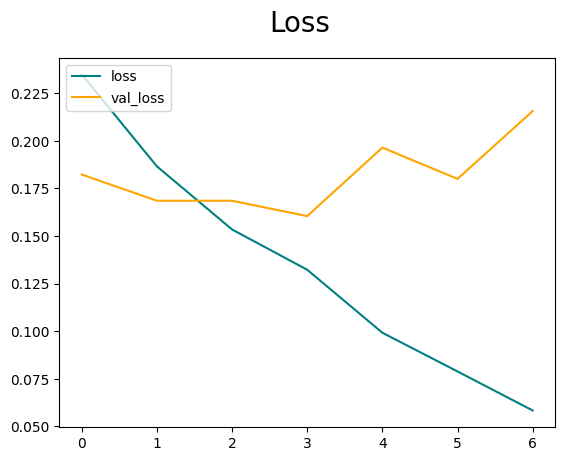

In [56]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

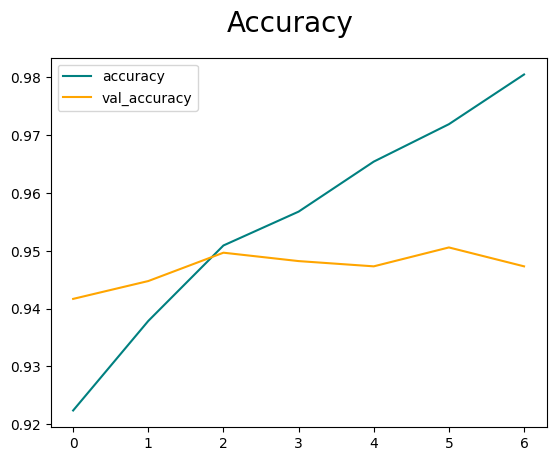

In [57]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [66]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [59]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [60]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 118ms/step


In [68]:
print("Precision : ",pre.result())
print("Recall : ",re.result())
print("Binary Accuracy : ",acc.result())

Precision :  tf.Tensor(0.9315254, shape=(), dtype=float32)
Recall :  tf.Tensor(0.97308785, shape=(), dtype=float32)
Binary Accuracy :  tf.Tensor(0.94949126, shape=(), dtype=float32)
